## Target guided encodings

In the previous lectures in this section, we learned how to convert a label into a number, by using one hot encoding, replacing by a digit or replacing by frequency or counts of observations. These methods are simple, make (almost) no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the target mean (mean encoding / target encoding)
- Replacing the labels by the probability ratio of the target being 1 or 0
- Weight of evidence.

All of the above methods have something in common:

- the encoding is **guided by the target**, and
- they create a **monotonic relationship** between the variable and the target.


### Monotonicity

A monotonic relationship is a relationship that does one of the following:

- (1) as the value of one variable increases, so does the value of the other variable; or
- (2) as the value of one variable increases, the value of the other variable decreases.

In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target value decreases.



### Advantages of target guided encodings

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


### Limitations

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries


### Note

The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

===============================================================================

## Mean Encoding or Target Encoding

Mean encoding implies replacing the category by the average target value for that category. For example, if we have the variable city, with categories London, Manchester and Bristol, and we want to predict the default rate, if the default rate for London is 30% we replace London by 0.3, if the default rate for Manchester is 20% we replace Manchester by 0.2 and so on.


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine

And the advantages and limitations of each implementation using the Titanic dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [2]:
# load dataset

data = pd.read_csv(
    '../titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# let's fill na in embarked

data['embarked'].fillna('Missing', inplace=True)

In [4]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [5]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  9  labels
embarked :  4  labels


In [6]:
# let's explore the unique categories

data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [7]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [8]:
data['embarked'].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Encoding important

We calculate the target mean per category using the train set, and then use those mappings in the test set.

Note that for the pandas implementation we need to keep the target in the training set:

In [9]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 4), (393, 4))

### Explore original relationship between categorical variables and target

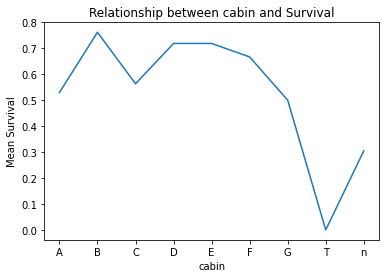

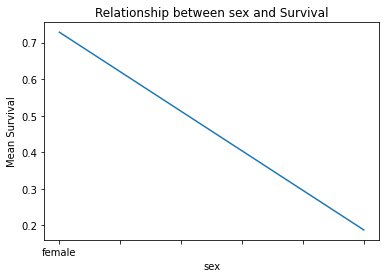

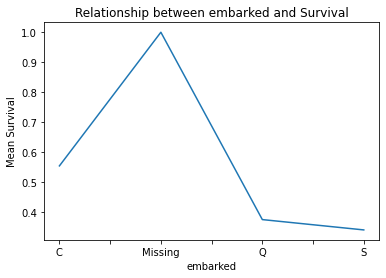

In [10]:
# let's explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Mean encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [11]:
# let's calculate the mean target value per category for cabin

X_train.groupby(['cabin'])['survived'].mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

In [12]:
# and now let's do the same but capturing the result in a dictionary

ordered_labels = X_train.groupby(['cabin'])['survived'].mean().to_dict()

ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [13]:
# now, we replace the labels with the target means

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [14]:
# let's explore the result

X_train['cabin'].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

In [15]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [16]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:
    mappings = find_category_mappings(X_train, variable, 'survived')
    integer_encode(X_train, X_test, variable, mappings)

In [17]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived
501,0.304843,0.728358,0.338957,1
588,0.304843,0.728358,0.338957,1
402,0.304843,0.728358,0.553073,1
1193,0.304843,0.187608,0.373494,0
686,0.304843,0.728358,0.373494,1


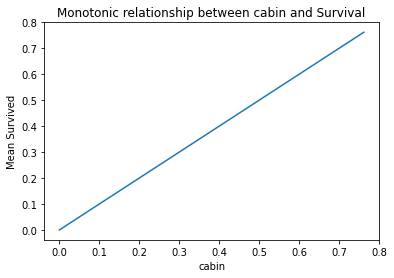

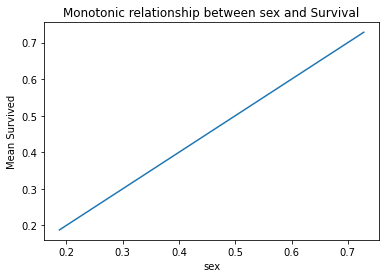

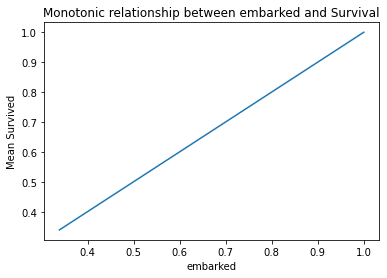

In [18]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Mean Encoding creates linear relationships between the mean target and the categories.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

## Mean Encoding with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [19]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 3), (393, 3))

In [20]:
mean_enc = MeanEncoder(
    variables=['cabin', 'sex', 'embarked'])

In [21]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['cabin', 'sex', 'embarked'])

In [22]:
# in the encoder dict we see the target mean assigned to each
# category for each of the selected variables

mean_enc.encoder_dict_

{'cabin': {'A': 0.5294117647058824,
  'B': 0.7619047619047619,
  'C': 0.5633802816901409,
  'D': 0.71875,
  'E': 0.71875,
  'F': 0.6666666666666666,
  'G': 0.5,
  'T': 0.0,
  'n': 0.30484330484330485},
 'sex': {'female': 0.7283582089552239, 'male': 0.18760757314974183},
 'embarked': {'C': 0.553072625698324,
  'Missing': 1.0,
  'Q': 0.37349397590361444,
  'S': 0.3389570552147239}}

In [23]:
# this is the list of variables that the encoder will transform

mean_enc.variables_

['cabin', 'sex', 'embarked']

In [24]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
501,0.304843,0.728358,0.338957
588,0.304843,0.728358,0.338957
402,0.304843,0.728358,0.553073
1193,0.304843,0.187608,0.373494
686,0.304843,0.728358,0.373494


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Finally, if there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.